# Set up

In [1]:
using Profile, ProfileSVG

In [2]:
cd("/Users/nbaker/Documents/GitHub/FLowFarm.jl/test")

In [24]:
using Snopt
using DelimitedFiles 
using PyPlot
import ForwardDiff

# set up boundary constraint wrapper function
function boundary_wrapper(x, params)
    # include relevant globals
    params.boundary_center
    params.boundary_radius

    # get number of turbines
    nturbines = Int(length(x)/2)
    
    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return boundary distances
    return ff.circle_boundary(boundary_center, boundary_radius, turbine_x, turbine_y)
end

# set up spacing constraint wrapper function
function spacing_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return spacing distances
    return 2.0*params.rotor_diameter[1] .- ff.turbine_spacing(turbine_x,turbine_y)
end

# set up objective wrapper function
function aep_wrapper(x, params)
    # include relevant globals
    params.turbine_z
    params.rotor_diameter
    params.hub_height
    params.turbine_yaw
    params.ct_models
    params.generator_efficiency
    params.cut_in_speed
    params.cut_out_speed
    params.rated_speed
    params.rated_power
    params.windresource
    params.power_models
    params.model_set
    params.rotor_points_y
    params.rotor_points_z
    params.obj_scale

    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines] 
    turbine_y = x[nturbines+1:end]

    # calculate AEP
    AEP = obj_scale*ff.calculate_aep(turbine_x, turbine_y, turbine_z, rotor_diameter,
                hub_height, turbine_yaw, ct_models, generator_efficiency, cut_in_speed,
                cut_out_speed, rated_speed, rated_power, windresource, power_models, model_set,
                rotor_sample_points_y=rotor_points_y,rotor_sample_points_z=rotor_points_z)
    
    # return the objective as an array
    return [AEP]
end

# set up optimization problem wrapper function
function wind_farm_opt(x)

    # calculate spacing constraint value and jacobian
    spacing_con = spacing_wrapper(x)
    ds_dx = ForwardDiff.jacobian(spacing_wrapper, x)
    println(length(ds_dx))
    # calculate boundary constraint and jacobian
    boundary_con = boundary_wrapper(x)
    db_dx = ForwardDiff.jacobian(boundary_wrapper, x)

    # combine constaint values and jacobians into overall constaint value and jacobian arrays
    c = [spacing_con; boundary_con]
    dcdx = [ds_dx; db_dx]

    # calculate the objective function and jacobian (negative sign in order to maximize AEP)
    AEP = -aep_wrapper(x)[1]
    dAEP_dx = -ForwardDiff.jacobian(aep_wrapper,x)

    # set fail flag to false
    fail = false

    # return objective, constraint, and jacobian values
    return AEP, c, dAEP_dx, dcdx, fail
end



wind_farm_opt (generic function with 2 methods)

In [ ]:
# set globals for use in wrapper functions
struct params_struct{MS, AF, F, ACTM, WR, APM}
    model_set::MS
    rotor_points_y::AF
    rotor_points_z::AF
    turbine_z::AF
    rotor_diameter::AF
    boundary_center::AF
    boundary_radius::F
    obj_scale::F
    hub_height::AF
    turbine_yaw::AF
    ct_models::ACTM
    generator_efficiency::AF
    cut_in_speed::AF
    cut_out_speed::AF
    rated_speed::AF
    rated_power::AF
    windresource::WR
    power_models::APM
end

In [ ]:
# import model set with wind farm and related details
revise()
include("./model_sets/model_set_9_38turb_round_farm.jl")

In [ ]:
# scale objective to be between 0 and 1
obj_scale = 1E-11
# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 1225.8227848101264
params = params_struct(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models)

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)
# report initial objective value
println("starting objective value: ", aep_wrapper(x, params)[1])

plot(0,0)
# add initial turbine location to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set general lower and upper bounds for design variables
lb = zeros(length(x)) .- boundary_radius
ub = zeros(length(x)) .+ boundary_radius

# set up options for SNOPT
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 0
options["Major optimality tolerance"] = 1e-6
options["Major iteration limit"] = 1e6
options["Summary file"] = "snopt_summary_ex6.out"
options["Print file"] = "snopt_print_ex6.out"

# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params)
aep_wrapper(x) = aep_wrapper(x, params)
boundary_wrapper(x) = boundary_wrapper(x, params)
obj_func(x) = wind_farm_opt(x)

# set up for WEC optimization
wec_steps = 2
wec_max = 3.0
wec_end = 1.0
wec_values = collect(LinRange(wec_max, wec_end, wec_steps))
println(wec_values)
info = fill("",wec_steps)
# run and time optimization
t1 = time()
xopt, fopt, info = snopt(obj_func, x, lb, ub, options)
t2 = time()
clk = t2-t1
# print optimization results
println("Finished in : ", clk, " (s)")
println("info: ", info)
println("end objective value: ", -fopt)

# extract final turbine locations
turbine_x = copy(xopt[1:nturbines])
turbine_y = copy(xopt[nturbines+1:end])

# add final turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C1", linestyle="--")) 
end

# add wind farm boundary to plot
plt.gcf().gca().add_artist(plt.Circle((boundary_center[1],boundary_center[2]), boundary_radius, fill=false,color="C2"))

# set up and show plot
axis("square")
xlim(-boundary_radius-200,boundary_radius+200)
ylim(-boundary_radius-200,boundary_radius+200)
plt.show()

# AEP Call

## Previous FlowFarm

In [ ]:
revise()

In [ ]:
@time ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)

In [ ]:
@time for i in 1:1000 ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

In [ ]:
@profview for i in 1:1000; ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

In [ ]:
# Using fastmath
@time for i in 1:1000 @fastmath ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

In [ ]:
@profview for i in 1:1000; @fastmath ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

Removed non-concrete type array and now
AEP calc did take 3.626610 (s)
Now AEP takes: 2.875312 (s)

Optimization with 38 turbines 12 directions was about 93 sec. now about 13 sec.


## Removing non-concrete type array in wake models

In [ ]:
revise()

In [ ]:
@time ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)

In [ ]:
@time for i in 1:1000 ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

In [ ]:
@profview for i in 1:1000; ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

## Remove loc array

In [ ]:
revise()

In [ ]:
@time ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)

In [ ]:
@time for i in 1:1000 ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

In [ ]:
@profview for i in 1:1000; ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z); end

# SNOPT call

In [ ]:
revise()

In [ ]:

# import model set with wind farm and related details
include("./model_sets/model_set_6.jl")

# scale objective to be between 0 and 1
obj_scale = 1E-11

# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 300.0

# initialize struct for opt params
params2 = params_struct(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models)

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)
# report initial objective value
println("starting objective value: ", aep_wrapper(x, params)[1])

# add initial turbine location to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set general lower and upper bounds for design variables
lb = zeros(length(x)) .- boundary_radius
ub = zeros(length(x)) .+ boundary_radius

# set up options for SNOPT
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 3
options["Major optimality tolerance"] = 1e-5
options["Major iteration limit"] = 1e6
options["Summary file"] = "./snopt-opt2-summary.out"
options["Print file"] = "./snopt-opt2-print.out"

# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params2)
aep_wrapper(x) = aep_wrapper(x, params2)
boundary_wrapper(x) = boundary_wrapper(x, params2)
obj_func(x) = wind_farm_opt(x)

# run and time optimization
t1 = time()
xopt, fopt, info = snopt(obj_func, x, lb, ub, options)
t2 = time()
clkt = t2-t1

# print optimization results
println("Finished in : ", clkt, " (s)")
println("info: ", info)
println("end objective value: ", aep_wrapper(xopt))

# extract final turbine locations
turbine_x = copy(xopt[1:nturbines])
turbine_y = copy(xopt[nturbines+1:end])

# add final turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C1", linestyle="--")) 
end

# add wind farm boundary to plot
plt.gcf().gca().add_artist(plt.Circle((boundary_center[1],boundary_center[2]), boundary_radius, fill=false,color="C2"))

# set up and show plot
axis("square")
xlim(-boundary_radius-200,boundary_radius+200)
ylim(-boundary_radius-200,boundary_radius+200)
plt.show()


In [ ]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

In [ ]:
@profview snopt(obj_func, deepcopy(xinit), lb, ub, options)

# Getting all results with a single call

In [4]:
using DiffResults

In [5]:
# set up optimization problem wrapper function using DiffResult
function wind_farm_opt(x)

    # calculate spacing constraint value and jacobian
    spacing_result = DiffResults.JacobianResult(zeros(length(x)*2),x)
    spacing_result = ForwardDiff.jacobian!(spacing_result, spacing_wrapper, x)
    spacing_con = DiffResults.value(spacing_result)
    ds_dx = DiffResults.jacobian(spacing_result)

    # calculate boundary constraint and jacobian
    boundary_result = DiffResults.JacobianResult(zeros(Int(length(x)/2)),x)
    boundary_result = ForwardDiff.jacobian!(boundary_result, boundary_wrapper, x)
    boundary_con = DiffResults.value(boundary_result)
    db_dx = DiffResults.jacobian(boundary_result)

    # combine constaint values and jacobians into overall constaint value and jacobian arrays
    c = [spacing_con; boundary_con]
    dcdx = [ds_dx; db_dx]

    # calculate the objective function and jacobian (negative sign in order to maximize AEP)
    obj_result = DiffResults.JacobianResult(zeros(1),x)
    obj_result = ForwardDiff.jacobian!(obj_result, aep_wrapper, x)
    AEP = -DiffResults.value(obj_result)
    dAEP_dx = -DiffResults.jacobian(obj_result)

    # set fail flag to false
    fail = false

    # return objective, constraint, and jacobian values
    return AEP[1], c, dAEP_dx, dcdx, fail
end

wind_farm_opt (generic function with 1 method)

In [6]:
# set globals for use in wrapper functions
struct params_struct6{MS, AF, F, ACTM, WR, APM, AC,AR}
    model_set::MS
    rotor_points_y::AF
    rotor_points_z::AF
    turbine_z::AF
    rotor_diameter::AF
    boundary_center::AF
    boundary_radius::F
    obj_scale::F
    hub_height::AF
    turbine_yaw::AF
    ct_models::ACTM
    generator_efficiency::AF
    cut_in_speed::AF
    cut_out_speed::AF
    rated_speed::AF
    rated_power::AF
    windresource::WR
    power_models::APM
    cfgs::AC
    results::AR
end

┌ Info: Precompiling FlowFarm [eb2d4cfc-2064-11ea-0a1c-63d372e6a848]
└ @ Base loading.jl:1260
┌ Warning: Package FlowFarm does not have ForwardDiff in its dependencies:
│ - If you have FlowFarm checked out for development and have
│   added ForwardDiff as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FlowFarm
└ Loading ForwardDiff into FlowFarm from project dependency, future warnings for FlowFarm are suppressed.


starting objective value: 0.33658078796656277
Finished in : 0.0 (s)
info: Finished successfully: optimality conditions satisfied
end objective value: 

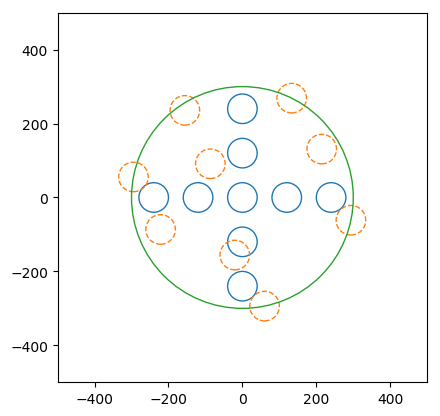

[0.5146096855017176]


In [7]:
# import model set with wind farm and related details
include("./model_sets/model_set_6.jl")

# scale objective to be between 0 and 1
obj_scale = 1E-11

# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 300.0

# initialize struct for opt params
params6 = params_struct6(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [1,1,1],[1])

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)
# report initial objective value
println("starting objective value: ", aep_wrapper(x, params6)[1])

# add initial turbine location to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set general lower and upper bounds for design variables
lb = zeros(length(x)) .- boundary_radius
ub = zeros(length(x)) .+ boundary_radius

# set up options for SNOPT
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 3
options["Major optimality tolerance"] = 1e-5
options["Major iteration limit"] = 1e6
options["Summary file"] = "./snopt-opt2-summary.out"
options["Print file"] = "./snopt-opt2-print.out"

# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params6)
aep_wrapper(x) = aep_wrapper(x, params6)
boundary_wrapper(x) = boundary_wrapper(x, params6)
obj_func(x) = wind_farm_opt(x)

# run and time optimization
t1 = time()
xopt, fopt, info = snopt(obj_func, x, lb, ub, options)
t2 = time()
clkt = t2-t1

# print optimization results
println("Finished in : ", clkt, " (s)")
println("info: ", info)
println("end objective value: ", aep_wrapper(xopt))

# extract final turbine locations
turbine_x = copy(xopt[1:nturbines])
turbine_y = copy(xopt[nturbines+1:end])

# add final turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C1", linestyle="--")) 
end

# add wind farm boundary to plot
plt.gcf().gca().add_artist(plt.Circle((boundary_center[1],boundary_center[2]), boundary_radius, fill=false,color="C2"))

# set up and show plot
axis("square")
xlim(-boundary_radius-200,boundary_radius+200)
ylim(-boundary_radius-200,boundary_radius+200)
plt.show()



In [8]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

  7.083151 seconds (11.67 M allocations: 1.361 GiB, 2.25% gc time)


In [ ]:
@profview snopt(obj_func, deepcopy(xinit), lb, ub, options)

# Defining Chunk Size and Pre-allocating jacobian config

In [9]:
# set up optimization problem wrapper function using DiffResult
function wind_farm_opt(x, params)
    
    # calculate spacing constraint value and jacobian
    spacing_result = params.results[1]
    spacing_result = ForwardDiff.jacobian!(spacing_result, spacing_wrapper, x, params.cfgs[1])
    spacing_con = DiffResults.value(spacing_result)
    ds_dx = DiffResults.jacobian(spacing_result)

    # calculate boundary constraint and jacobian
    boundary_result = params.results[2]
    boundary_result = ForwardDiff.jacobian!(boundary_result, boundary_wrapper, x, params.cfgs[2])
    boundary_con = DiffResults.value(boundary_result)
    db_dx = DiffResults.jacobian(boundary_result)

    # combine constaint values and jacobians into overall constaint value and jacobian arrays
    c = [spacing_con; boundary_con]
    dcdx = [ds_dx; db_dx]

    # calculate the objective function and jacobian (negative sign in order to maximize AEP)
    obj_result = params.results[3]
    obj_result = ForwardDiff.jacobian!(obj_result, aep_wrapper, x, params.cfgs[3])
    AEP = -DiffResults.value(obj_result)
    dAEP_dx = -DiffResults.jacobian(obj_result)

    # set fail flag to false
    fail = false

    # return objective, constraint, and jacobian values
    return AEP[1], c, dAEP_dx, dcdx, fail
end

wind_farm_opt (generic function with 2 methods)

starting objective value: 0.33658078796656277
Finished in : 

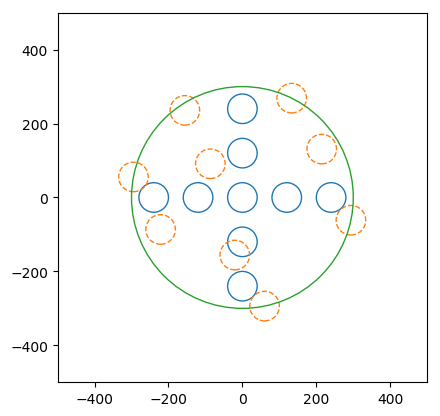

0.0 (s)
info: Finished successfully: optimality conditions satisfied
end objective value: [0.5146096855017176]


In [10]:
# import model set with wind farm and related details
include("./model_sets/model_set_6.jl")

# scale objective to be between 0 and 1
obj_scale = 1E-11

# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 300.0

# initialize struct for opt params
spacing_chunk_size = 18
# spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x, ForwardDiff.Chunk{spacing_chunk_size}())
spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x)
spacing_result = DiffResults.JacobianResult(zeros(length(x)*2),x)

boundary_chunk_size = 18
# boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x, ForwardDiff.Chunk{boundary_chunk_size}())
boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x)
boundary_result = DiffResults.JacobianResult(zeros(Int(length(x)/2)),x)

obj_chunk_size = 18
# obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x, ForwardDiff.Chunk{obj_chunk_size}())
obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x)
obj_result = DiffResults.JacobianResult(zeros(1), x)

params6 = params_struct6(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [spacing_cfg, boundary_cfg, obj_cfg], [spacing_result, boundary_result, obj_result])

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)
# report initial objective value
println("starting objective value: ", aep_wrapper(x, params6)[1])

# add initial turbine location to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set general lower and upper bounds for design variables
lb = zeros(length(x)) .- boundary_radius
ub = zeros(length(x)) .+ boundary_radius

# set up options for SNOPT
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 3
options["Major optimality tolerance"] = 1e-5
options["Major iteration limit"] = 1e6
options["Summary file"] = "./snopt-opt2-summary.out"
options["Print file"] = "./snopt-opt2-print.out"

# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params6)
aep_wrapper(x) = aep_wrapper(x, params6)
boundary_wrapper(x) = boundary_wrapper(x, params6)
obj_func(x) = wind_farm_opt(x, params6)

# run and time optimization
t1 = time()
xopt, fopt, info = snopt(obj_func, x, lb, ub, options)
t2 = time()
clkt = t2-t1

# print optimization results
println("Finished in : ", clkt, " (s)")
println("info: ", info)
println("end objective value: ", aep_wrapper(xopt))

# extract final turbine locations
turbine_x = copy(xopt[1:nturbines])
turbine_y = copy(xopt[nturbines+1:end])

# add final turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C1", linestyle="--")) 
end

# add wind farm boundary to plot
plt.gcf().gca().add_artist(plt.Circle((boundary_center[1],boundary_center[2]), boundary_radius, fill=false,color="C2"))

# set up and show plot
axis("square")
xlim(-boundary_radius-200,boundary_radius+200)
ylim(-boundary_radius-200,boundary_radius+200)
plt.show()




In [11]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

  7.730446 seconds (33.41 M allocations: 1.579 GiB, 2.60% gc time)


In [12]:
spacing_chunk_size = 18
spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x, ForwardDiff.Chunk{spacing_chunk_size}())

boundary_chunk_size = 18
boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x, ForwardDiff.Chunk{boundary_chunk_size}())

obj_chunk_size = 18
obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x, ForwardDiff.Chunk{obj_chunk_size}())

params7 = params_struct6(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [spacing_cfg, boundary_cfg, obj_cfg], [spacing_result, boundary_result, obj_result])

# params6.cfgs[1] = spacing_cfg
# params6.cfgs[2] = boundary_cfg
# params6.cfgs[3] = obj_cfg

obj_func(x) = wind_farm_opt(x, params7)

obj_func (generic function with 1 method)

In [13]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

 11.466235 seconds (36.49 M allocations: 1.788 GiB, 3.53% gc time)


In [25]:
spacing_chunk_size = 9
spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x, ForwardDiff.Chunk{spacing_chunk_size}())

boundary_chunk_size = 9
boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x, ForwardDiff.Chunk{boundary_chunk_size}())

obj_chunk_size = 9
obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x, ForwardDiff.Chunk{obj_chunk_size}())

params7 = params_struct6(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [spacing_cfg, boundary_cfg, obj_cfg], [spacing_result, boundary_result, obj_result])
# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params7)
aep_wrapper(x) = aep_wrapper(x, params7)
boundary_wrapper(x) = boundary_wrapper(x, params7)
obj_func(x) = wind_farm_opt(x, params7)

obj_func (generic function with 1 method)

In [26]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

  8.198858 seconds (34.27 M allocations: 1.623 GiB, 3.00% gc time)


It looks like the main benefit here is pre-configuring the jacobian call

In [ ]:
@profview snopt(obj_func, deepcopy(xinit), lb, ub, options)

# Making use of sparsity for constraint calculations

In [50]:
using SparseDiffTools, SparsityDetection, SparseArrays, Cassette

In [207]:
# set globals for use in wrapper functions
struct params_struct_cache{MS, AF, F, ACTM, WR, APM, AJC}
    model_set::MS
    rotor_points_y::AF
    rotor_points_z::AF
    turbine_z::AF
    rotor_diameter::AF
    boundary_center::AF
    boundary_radius::F
    obj_scale::F
    hub_height::AF
    turbine_yaw::AF
    ct_models::ACTM
    generator_efficiency::AF
    cut_in_speed::AF
    cut_out_speed::AF
    rated_speed::AF
    rated_power::AF
    windresource::WR
    power_models::APM
    jac_cache::AJC
end

In [295]:
using Snopt
using DelimitedFiles 
using PyPlot
import ForwardDiff

# set up boundary constraint wrapper function
function boundary_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)
    
    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return boundary distances
    return ff.circle_boundary(params.boundary_center, params.boundary_radius, turbine_x, turbine_y)
end

# set up spacing constraint wrapper function
function spacing_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return spacing distances
    return 2.0*params.rotor_diameter[1] .- ff.turbine_spacing(turbine_x,turbine_y)
end

# set up objective wrapper function
function aep_wrapper(x, params)

    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines] 
    turbine_y = x[nturbines+1:end]

    # calculate AEP
    AEP = obj_scale*ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
                params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
                params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)
    
    # return the objective as an array
    return [AEP]
end

# set up optimization problem wrapper function
function wind_farm_opt(x, params)

    # calculate spacing constraint value and jacobian
    
    spacing_con = spacing_wrapper(x)
#     xrand = rand(Int(length(x)))
#     spacing_sparcity = sparse(ForwardDiff.jacobian(spacing_wrapper, xrand))
#     for i in 1:size(spacing_sparcity)[1]
#         for j in 1:size(spacing_sparcity)[2]
#             if spacing_sparcity[i,j] != 0
#                 spacing_sparcity[i,j] = 1.0
#             end
#         end
#     end

#     spacing_colors = matrix_colors(spacing_sparcity)
    
#     ds_dx = forwarddiff_color_jacobian(spacing_wrapper, x,
#                                     dx = spacing_con,
#                                     colorvec = params.jac_cache[2],
#                                     sparsity = params.jac_cache[3])
    
    ds_dx = forwarddiff_color_jacobian(spacing_wrapper, x, spacing_jac_cache)
    
    # calculate boundary constraint and jacobian
    boundary_con = boundary_wrapper(x)
    db_dx = ForwardDiff.jacobian(boundary_wrapper, x)

    # combine constaint values and jacobians into overall constaint value and jacobian arrays
    c = [spacing_con; boundary_con]
    dcdx = [ds_dx; db_dx]

    # calculate the objective function and jacobian (negative sign in order to maximize AEP)
    AEP = -aep_wrapper(x)[1]
    dAEP_dx = -ForwardDiff.jacobian(aep_wrapper,x)

    # set fail flag to false
    fail = false

    # return objective, constraint, and jacobian values
    return AEP, c, dAEP_dx, dcdx, fail
end



wind_farm_opt (generic function with 2 methods)

starting objective value: 0.33658078796656277
Finished in : 

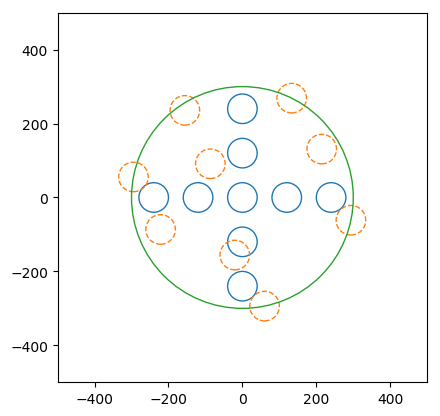

5.001971006393433 (s)
info: Finished successfully: optimality conditions satisfied
end objective value: [0.5146096855017176]


In [302]:
# import model set with wind farm and related details
include("./model_sets/model_set_6.jl")

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)

# scale objective to be between 0 and 1
obj_scale = 1E-11

# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 300.0

# initialize struct for opt params
# use rand x values so that the inherent structure does not cloud the true sparsity pattern
xrand = rand(Int(length(x)))
spacing_output = spacing_wrapper(xrand)
spacing_sparcity = sparse(ForwardDiff.jacobian(spacing_wrapper, xrand))
for i in 1:size(spacing_sparcity)[1]
    for j in 1:size(spacing_sparcity)[2]
        if spacing_sparcity[i,j] != 0
            spacing_sparcity[i,j] = 1.0
        end
    end
end
# get color vector
spacing_colors = matrix_colors(spacing_sparcity)
# cache jacobian config
spacing_jac_cache = ForwardColorJacCache(spacing_wrapper, xinit,
                              dx=spacing_output,
                              colorvec=spacing_colors,
                              sparsity=spacing_sparcity)
spacing_chunk_size = 18
# spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x, ForwardDiff.Chunk{spacing_chunk_size}())
spacing_cfg = ForwardDiff.JacobianConfig(spacing_wrapper, x)
spacing_result = DiffResults.JacobianResult(zeros(length(x)*2),x)

boundary_chunk_size = 18
# boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x, ForwardDiff.Chunk{boundary_chunk_size}())
boundary_cfg = ForwardDiff.JacobianConfig(boundary_wrapper, x)
boundary_result = DiffResults.JacobianResult(zeros(Int(length(x)/2)),x)

obj_chunk_size = 18
# obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x, ForwardDiff.Chunk{obj_chunk_size}())
obj_cfg = ForwardDiff.JacobianConfig(aep_wrapper, x)
obj_result = DiffResults.JacobianResult(zeros(1), x)

params6 = params_struct_cache(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [spacing_jac_cache])

# report initial objective value
println("starting objective value: ", aep_wrapper(x, params6)[1])

# add initial turbine location to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set general lower and upper bounds for design variables
lb = zeros(length(x)) .- boundary_radius
ub = zeros(length(x)) .+ boundary_radius

# set up options for SNOPT
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 3
options["Major optimality tolerance"] = 1e-5
options["Major iteration limit"] = 1e6
options["Summary file"] = "./snopt-opt2-summary.out"
options["Print file"] = "./snopt-opt2-print.out"

# generate wrapper function surrogates
spacing_wrapper(x) = spacing_wrapper(x, params6)
aep_wrapper(x) = aep_wrapper(x, params6)
boundary_wrapper(x) = boundary_wrapper(x, params6)
obj_func(x) = wind_farm_opt(x, params6)

# run and time optimization
t1 = time()
xopt, fopt, info = snopt(obj_func, x, lb, ub, options)
t2 = time()
clkt = t2-t1

# print optimization results
println("Finished in : ", clkt, " (s)")
println("info: ", info)
println("end objective value: ", aep_wrapper(xopt))

# extract final turbine locations
turbine_x = copy(xopt[1:nturbines])
turbine_y = copy(xopt[nturbines+1:end])

# add final turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C1", linestyle="--")) 
end

# add wind farm boundary to plot
plt.gcf().gca().add_artist(plt.Circle((boundary_center[1],boundary_center[2]), boundary_radius, fill=false,color="C2"))

# set up and show plot
axis("square")
xlim(-boundary_radius-200,boundary_radius+200)
ylim(-boundary_radius-200,boundary_radius+200)
plt.show()

In [299]:
@time for i in 1:10 snopt(obj_func, deepcopy(xinit), lb, ub, options) end

1031.327787 seconds (9.97 G allocations: 229.960 GiB, 3.13% gc time)


In [194]:
# get sparsity pattern for spacing wrapper
input = xinit
output = spacing_sparsity_wrapper(xinit)

36×18 Array{Float64,2}:
  0.707107  -0.707107  -0.0       …  -0.0       -0.0       -0.0
  1.0       -0.0       -1.0          -0.0       -0.0       -0.0
  0.707107  -0.0       -0.0          -0.0       -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.894427  -0.0       -0.0       …  -0.447214  -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.894427  -0.0       -0.0          -0.0       -0.0        0.447214
 -0.0        0.707107  -0.707107     -0.0       -0.0       -0.0
 -0.0        0.0       -0.0          -0.0       -0.0       -0.0
 -0.0        0.0       -0.0       …  -0.0       -0.0       -0.0
  0.0       -0.447214   0.0           0.0        0.0        0.0
 -0.0        0.0       -0.0           1.0       -0.0       -0.0
  ⋮                               ⋱   ⋮                    
 -0.0       -0.0       -0.0          -0.0       -0.894427  -0.0
 -0.0       -0.

In [195]:
ForwardDiff.jacobian(spacing_wrapper, xinit)

36×18 Array{Float64,2}:
  0.707107  -0.707107  -0.0       …  -0.0       -0.0       -0.0
  1.0       -0.0       -1.0          -0.0       -0.0       -0.0
  0.707107  -0.0       -0.0          -0.0       -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.894427  -0.0       -0.0       …  -0.447214  -0.0       -0.0
  1.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.894427  -0.0       -0.0          -0.0       -0.0        0.447214
 -0.0        0.707107  -0.707107     -0.0       -0.0       -0.0
 -0.0        0.0       -0.0          -0.0       -0.0       -0.0
 -0.0        0.0       -0.0       …  -0.0       -0.0       -0.0
  0.0       -0.447214   0.0           0.0        0.0        0.0
 -0.0        0.0       -0.0           1.0       -0.0       -0.0
  ⋮                               ⋱   ⋮                    
 -0.0       -0.0       -0.0          -0.0       -0.894427  -0.0
 -0.0       -0.

In [196]:
jac = sparse(output)

36×18 SparseMatrixCSC{Float64,Int64} with 104 stored entries:
  [1 ,  1]  =  0.707107
  [2 ,  1]  =  1.0
  [3 ,  1]  =  0.707107
  [4 ,  1]  =  1.0
  [5 ,  1]  =  1.0
  [6 ,  1]  =  0.894427
  [7 ,  1]  =  1.0
  [8 ,  1]  =  0.894427
  [1 ,  2]  =  -0.707107
  [9 ,  2]  =  0.707107
  [12,  2]  =  -0.447214
  [14,  2]  =  0.447214
  ⋮
  [35, 16]  =  -1.0
  [14, 17]  =  0.894427
  [25, 17]  =  -0.894427
  [34, 17]  =  0.707107
  [36, 17]  =  -0.707107
  [8 , 18]  =  0.447214
  [15, 18]  =  1.0
  [21, 18]  =  0.447214
  [26, 18]  =  -1.0
  [30, 18]  =  1.0
  [33, 18]  =  0.707107
  [35, 18]  =  1.0
  [36, 18]  =  0.707107

In [197]:
for i in 1:size(jac)[1]
    for j in 1:size(jac)[2]
        if jac[i,j] != 0
            jac[i,j] = 1.0
        end
    end
end
jac

36×18 SparseMatrixCSC{Float64,Int64} with 104 stored entries:
  [1 ,  1]  =  1.0
  [2 ,  1]  =  1.0
  [3 ,  1]  =  1.0
  [4 ,  1]  =  1.0
  [5 ,  1]  =  1.0
  [6 ,  1]  =  1.0
  [7 ,  1]  =  1.0
  [8 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [9 ,  2]  =  1.0
  [12,  2]  =  1.0
  [14,  2]  =  1.0
  ⋮
  [35, 16]  =  1.0
  [14, 17]  =  1.0
  [25, 17]  =  1.0
  [34, 17]  =  1.0
  [36, 17]  =  1.0
  [8 , 18]  =  1.0
  [15, 18]  =  1.0
  [21, 18]  =  1.0
  [26, 18]  =  1.0
  [30, 18]  =  1.0
  [33, 18]  =  1.0
  [35, 18]  =  1.0
  [36, 18]  =  1.0

In [198]:
colors = matrix_colors(jac)

18-element Array{Int64,1}:
 1
 2
 3
 2
 2
 4
 2
 5
 2
 3
 6
 1
 7
 1
 1
 8
 1
 9

In [199]:
jacout = forwarddiff_color_jacobian(spacing_wrapper, input,
                                    dx = output,
                                    colorvec = colors,
                                    sparsity = jac,
                                    jac_prototype = jac)

36×18 SparseMatrixCSC{Float64,Int64} with 104 stored entries:
  [1 ,  1]  =  0.707107
  [2 ,  1]  =  1.0
  [3 ,  1]  =  0.707107
  [4 ,  1]  =  1.0
  [5 ,  1]  =  1.0
  [6 ,  1]  =  0.894427
  [7 ,  1]  =  1.0
  [8 ,  1]  =  0.894427
  [1 ,  2]  =  -0.707107
  [9 ,  2]  =  0.707107
  [12,  2]  =  -0.447214
  [14,  2]  =  0.447214
  ⋮
  [35, 16]  =  -1.0
  [14, 17]  =  0.894427
  [25, 17]  =  -0.894427
  [34, 17]  =  0.707107
  [36, 17]  =  -0.707107
  [8 , 18]  =  0.447214
  [15, 18]  =  1.0
  [21, 18]  =  0.447214
  [26, 18]  =  -1.0
  [30, 18]  =  1.0
  [33, 18]  =  0.707107
  [35, 18]  =  1.0
  [36, 18]  =  0.707107

In [222]:
spacing_output = spacing_wrapper(xinit)
spacing_sparcity = sparse(ForwardDiff.jacobian(spacing_wrapper, xinit))
for i in 1:size(jac)[1]
    for j in 1:size(jac)[2]
        if spacing_sparcity[i,j] != 0
            spacing_sparcity[i,j] = 1.0
        end
    end
end
spacing_colors = matrix_colors(spacing_sparcity)
spacing_jac_cache = ForwardColorJacCache(spacing_wrapper,x,
                              dx = spacing_output,
                              colorvec=spacing_colors,
                              sparsity = spacing_sparcity)

jacout == forwarddiff_color_jacobian(spacing_wrapper, xinit, spacing_jac_cache)

true

In [171]:
function g(x) # out-of-place
  global fcalls += 1
  dx = zero(x)
  for i in 2:length(x)-1
    dx[i] = (x[i-1] - 2x[i] + x[i+1])^2
  end
  dx[1] = -2x[1] + x[2]
  dx[end] = x[end-1] - 2x[end]
  dx
end

g (generic function with 1 method)

In [186]:
using Random
Random.seed!(10)
input = rand(30)
output = similar(input)
sparsity_pattern = jacobian_sparsity(f,output,input)
jac = Float64.(sparse(sparsity_pattern))
for i in 1:size(jac)[1]
    for j in 1:size(jac)[2]
        if jac[i,j] != 0
            jac[i,j] = 1.0
        end
    end
end
jac

Explored path: SparsityDetection.Path(Bool[], 1)


30×30 SparseMatrixCSC{Float64,Int64} with 88 stored entries:
  [1 ,  1]  =  1.0
  [2 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [2 ,  2]  =  1.0
  [3 ,  2]  =  1.0
  [2 ,  3]  =  1.0
  [3 ,  3]  =  1.0
  [4 ,  3]  =  1.0
  [3 ,  4]  =  1.0
  [4 ,  4]  =  1.0
  [5 ,  4]  =  1.0
  [4 ,  5]  =  1.0
  ⋮
  [26, 26]  =  1.0
  [27, 26]  =  1.0
  [26, 27]  =  1.0
  [27, 27]  =  1.0
  [28, 27]  =  1.0
  [27, 28]  =  1.0
  [28, 28]  =  1.0
  [29, 28]  =  1.0
  [28, 29]  =  1.0
  [29, 29]  =  1.0
  [30, 29]  =  1.0
  [29, 30]  =  1.0
  [30, 30]  =  1.0

In [187]:
colors = matrix_colors(jac)

30-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 ⋮
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 2
 3

In [188]:
jacout = forwarddiff_color_jacobian(g, input,
                                    dx = similar(input),
                                    colorvec = 1:length(input),
                                    sparsity = nothing,
                                    jac_prototype = nothing)

30×30 Array{Float64,2}:
 -2.0        1.0        0.0       …  0.0        0.0        0.0
 -0.559183   1.11837   -0.559183     0.0        0.0        0.0
  0.0       -0.527897   1.05579      0.0        0.0        0.0
  0.0        0.0        0.703887     0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0       …  0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0       …  0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0          0.0        0.0        0.0
  ⋮                               ⋱                       
  0.0        0.0        0.0          0.0        0.0        0.0
  0.0        0.0        0.0        

In [189]:
jacout = ForwardDiff.jacobian(g, input)

30×30 Array{Float64,2}:
 -2.0        1.0        0.0       …   0.0        0.0        0.0
 -0.559183   1.11837   -0.559183     -0.0       -0.0       -0.0
 -0.0       -0.527897   1.05579      -0.0       -0.0       -0.0
  0.0        0.0        0.703887      0.0        0.0        0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.0        0.0        0.0       …   0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0       …  -0.0       -0.0       -0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
  ⋮                               ⋱                        
  0.0        0.0        0.0           0.0        0.0        0.0
 -0.0       -0.0    

In [190]:
jac = sparse(jacout)

30×30 SparseMatrixCSC{Float64,Int64} with 88 stored entries:
  [1 ,  1]  =  -2.0
  [2 ,  1]  =  -0.559183
  [1 ,  2]  =  1.0
  [2 ,  2]  =  1.11837
  [3 ,  2]  =  -0.527897
  [2 ,  3]  =  -0.559183
  [3 ,  3]  =  1.05579
  [4 ,  3]  =  0.703887
  [3 ,  4]  =  -0.527897
  [4 ,  4]  =  -1.40777
  [5 ,  4]  =  -0.0106831
  [4 ,  5]  =  0.703887
  ⋮
  [26, 26]  =  1.00851
  [27, 26]  =  0.921003
  [26, 27]  =  -0.504254
  [27, 27]  =  -1.84201
  [28, 27]  =  -0.124843
  [27, 28]  =  0.921003
  [28, 28]  =  0.249686
  [29, 28]  =  0.338252
  [28, 29]  =  -0.124843
  [29, 29]  =  -0.676503
  [30, 29]  =  1.0
  [29, 30]  =  0.338252
  [30, 30]  =  -2.0

In [191]:
colors = matrix_colors(jac)

30-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 ⋮
 1
 2
 3
 1
 2
 3
 1
 2
 3
 1
 2
 3

In [192]:
jacout = forwarddiff_color_jacobian(g, input,
                                    dx = similar(input),
                                    colorvec = colors,
                                    sparsity = jac,
                                    jac_prototype = jac)

30×30 SparseMatrixCSC{Float64,Int64} with 88 stored entries:
  [1 ,  1]  =  -2.0
  [2 ,  1]  =  -0.559183
  [1 ,  2]  =  1.0
  [2 ,  2]  =  1.11837
  [3 ,  2]  =  -0.527897
  [2 ,  3]  =  -0.559183
  [3 ,  3]  =  1.05579
  [4 ,  3]  =  0.703887
  [3 ,  4]  =  -0.527897
  [4 ,  4]  =  -1.40777
  [5 ,  4]  =  -0.0106831
  [4 ,  5]  =  0.703887
  ⋮
  [26, 26]  =  1.00851
  [27, 26]  =  0.921003
  [26, 27]  =  -0.504254
  [27, 27]  =  -1.84201
  [28, 27]  =  -0.124843
  [27, 28]  =  0.921003
  [28, 28]  =  0.249686
  [29, 28]  =  0.338252
  [28, 29]  =  -0.124843
  [29, 29]  =  -0.676503
  [30, 29]  =  1.0
  [29, 30]  =  0.338252
  [30, 30]  =  -2.0

# Timing Jacobian Calculations

## Setup

In [319]:
struct params_struct_cache3{MS, AF, F, ACTM, WR, APM, AJC,A}
    model_set::MS
    rotor_points_y::AF
    rotor_points_z::AF
    turbine_z::AF
    rotor_diameter::AF
    boundary_center::AF
    boundary_radius::F
    obj_scale::F
    hub_height::AF
    turbine_yaw::AF
    ct_models::ACTM
    generator_efficiency::AF
    cut_in_speed::AF
    cut_out_speed::AF
    rated_speed::AF
    rated_power::AF
    windresource::WR
    power_models::APM
    jac_cache::AJC
    in1::A
    in2::A
    in3::A
    in4::A
    in5::A
    in6::A
end

In [348]:
# import model set with wind farm and related details
include("./model_sets/model_set_6.jl")

# initialize design variable array
x = [copy(turbine_x);copy(turbine_y)]
xinit = deepcopy(x)

# scale objective to be between 0 and 1
obj_scale = 1E-11

# set wind farm boundary parameters
boundary_center = [0.0,0.0]
boundary_radius = 300.0


paramstime = params_struct_cache3(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [spacing_jac_cache],[],[],[],[],[],[])
println("Setup complete")

Setup complete


## Original Functions

### Spacing

In [349]:
function turbine_spacing(turbine_x, turbine_y)
    nturbines = length(turbine_x)
    spacing_vec =
        zeros(typeof(turbine_x[1]), Int((nturbines) * (nturbines - 1) / 2))
    k = 1
    for i in 1:nturbines
        for j in i+1:nturbines
            spacing_vec[k] = sqrt(
                (turbine_x[j] - turbine_x[i])^2 +
                (turbine_y[j] - turbine_y[i])^2,
            )
            k += 1
        end
    end
    return spacing_vec
end

turbine_spacing (generic function with 1 method)

In [350]:

# set up spacing constraint wrapper function
function spacing_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return spacing distances
    return 2.0*params.rotor_diameter[1] .- turbine_spacing(turbine_x,turbine_y)
end
spacing_wrapper(x) = spacing_wrapper(x, paramstime)


spacing_wrapper (generic function with 2 methods)

### Boundary

In [351]:
function circle_boundary(center, radius, turbine_x, turbine_y)
    nturbines = length(turbine_x)
    boundary_vec = zeros(typeof(turbine_x[1]), nturbines)
    for i in 1:nturbines
        boundary_vec[i] =
            sqrt((center[1] - turbine_x[i])^2 + (center[2] - turbine_y[i])^2) -
            radius
    end
    return boundary_vec
end

circle_boundary (generic function with 1 method)

In [352]:
# set up boundary constraint wrapper function
function boundary_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)
    
    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return boundary distances
    return circle_boundary(params.boundary_center, params.boundary_radius, turbine_x, turbine_y)
end



boundary_wrapper (generic function with 2 methods)

### AEP

In [353]:
# set up objective wrapper function
function aep_wrapper(x, params)

    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines] 
    turbine_y = x[nturbines+1:end]

    # calculate AEP
    AEP = obj_scale*ff.calculate_state_aeps(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
    params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
    params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)
    
    # return the objective as an array
    return AEP
end
aep_wrapper(x) = aep_wrapper(x,paramstime)

aep_wrapper (generic function with 2 methods)

# Timing Jacobian Calculations on AEP Function

In [354]:
using BenchmarkTools

## AEP Only

In [358]:
@benchmark aep_wrapper(x) setup=(x=xinit)

BenchmarkTools.Trial: 
  memory estimate:  6.44 KiB
  allocs estimate:  52
  --------------
  minimum time:     24.989 μs (0.00% GC)
  median time:      25.823 μs (0.00% GC)
  mean time:        27.652 μs (2.91% GC)
  maximum time:     8.081 ms (99.53% GC)
  --------------
  samples:          10000
  evals/sample:     1

## AEP Jacobian using ForwardDiff.jacobian()

In [359]:
@benchmark ForwardDiff.jacobian(aep_wrapper, x) setup=(x=xinit)

BenchmarkTools.Trial: 
  memory estimate:  71.22 KiB
  allocs estimate:  257
  --------------
  minimum time:     199.750 μs (0.00% GC)
  median time:      204.831 μs (0.00% GC)
  mean time:        220.158 μs (3.82% GC)
  maximum time:     8.023 ms (96.86% GC)
  --------------
  samples:          10000
  evals/sample:     1

## AEP Jacobian using ForwardDiff.jacobian() with cacheing

In [360]:
obj_result = DiffResults.JacobianResult(zeros(3),xinit)
@benchmark ForwardDiff.jacobian!(obj_result, aep_wrapper, x) setup=(x=xinit)

BenchmarkTools.Trial: 
  memory estimate:  70.69 KiB
  allocs estimate:  256
  --------------
  minimum time:     199.521 μs (0.00% GC)
  median time:      204.624 μs (0.00% GC)
  mean time:        220.641 μs (4.05% GC)
  maximum time:     9.785 ms (96.95% GC)
  --------------
  samples:          10000
  evals/sample:     1

The above call calculates both the jacobian and the AEP output value in less time than the uncached call calculates the jacobian alone

## AEP Jacobian using coloring and cacheing

In [347]:
xrand = rand(Int(length(x)))
aep_output = aep_wrapper(xrand)
aep_sparcity = sparse(ForwardDiff.jacobian(aep_wrapper, xrand))
for i in 1:size(aep_sparcity)[1]
    for j in 1:size(aep_sparcity)[2]
        if aep_sparcity[i,j] != 0
            aep_sparcity[i,j] = 1.0
        end
    end
end
# get color vector
aep_colors = matrix_colors(aep_sparcity)
# cache jacobian config
aep_jac_cache = ForwardColorJacCache(aep_wrapper, xinit,
                              dx=aep_output,
                              colorvec=aep_colors,
                              sparsity=aep_sparcity)

ForwardColorJacCache{Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64},Float64,4},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64},Float64,4},1},Array{Float64,1},Array{Array{NTuple{4,Bool},1},1},Array{Int64,1},SparseMatrixCSC{Float64,Int64}}(ForwardDiff.Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64},Float64,4}[Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(-240.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(0.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(240.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(0.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(0.0,0.0,1.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(-120.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(0.0,1.0,0.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(120.0,0.0,1.0,0.0,0.0), Dual{ForwardDiff.Tag{typeof(aep_wrapper),Float64}}(